<a href="https://colab.research.google.com/github/JoelBenesh/marked-beetle-analysis-1/blob/main/EfficientNetB0_with_original_images_from_MarkedBeetleImageAnalysis_Ventral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]

['PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif',
 'PaperedControl21v_light.tif']

In [4]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if "v" in filename:
        if filename.startswith('Papered') or filename.startswith('NoPapered'):
          train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 379


In [5]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [6]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

379

In [7]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl21v.tif,marked
1,PaperedControl22v.tif,marked
2,PaperedControl23v.tif,marked
3,PaperedControl24v.tif,marked
4,PaperedControl25v.tif,marked
...,...,...
374,PaperedControl16v.tif,marked
375,PaperedControl17v.tif,marked
376,PaperedControl18v.tif,marked
377,PaperedControl19v.tif,marked


In [8]:
df['category'].value_counts()

marked      240
unmarked    139
Name: category, dtype: int64

In [9]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [10]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [11]:
tmp_df = df.sample(9)
tmp_df

,filename,category
244,NoPaperedGreen86v.tif,unmarked
369,PaperedControl11v.tif,marked
224,NoPaperedGreen66v.tif,unmarked
19,PaperedControl39v.tif,marked
201,NoPaperedGreen43v.tif,unmarked
135,PaperedTransparent76v.tif,marked
183,NoPaperedGreen22v.tif,unmarked
42,PaperedControl62v.tif,marked
162,PaperedTransparent103v.tif,marked


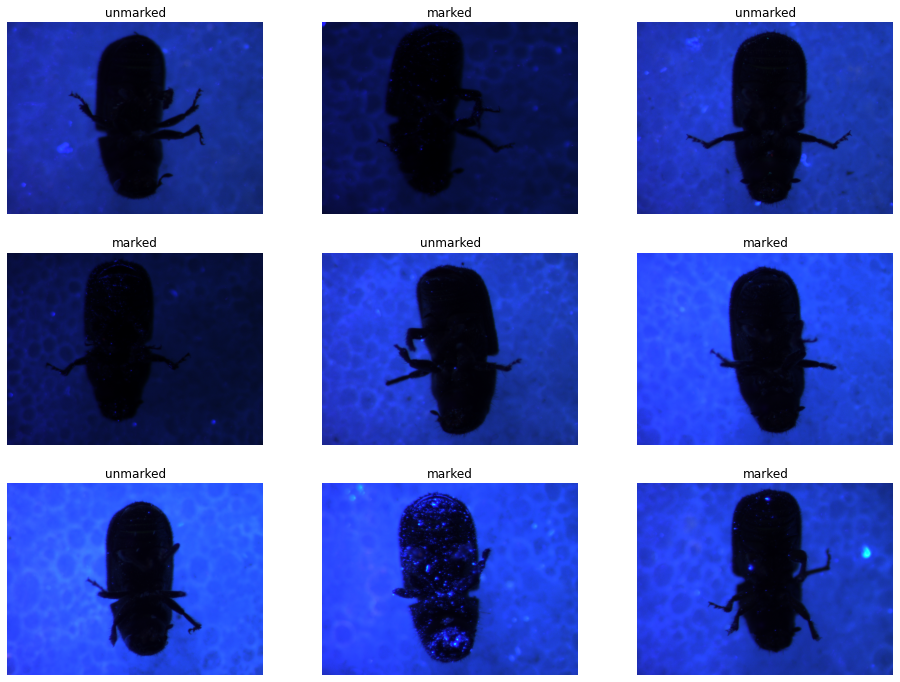

In [12]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [13]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

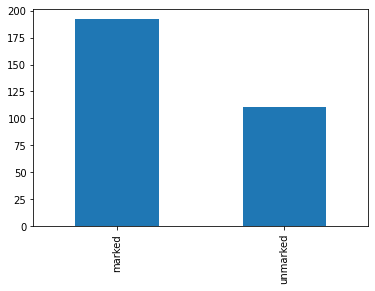

In [15]:
train_df['category'].value_counts().plot.bar()

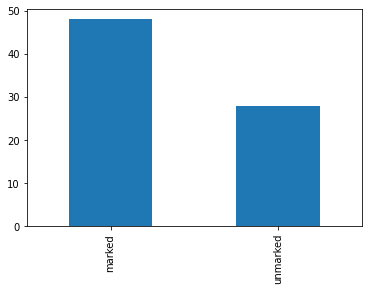

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 50

In [18]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [19]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [20]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 303 validated image filenames belonging to 2 classes.


In [21]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 76 validated image filenames belonging to 2 classes.


In [22]:
from tensorflow.keras import layers
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [23]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
def create_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________

In [24]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [25]:
def Model_fit():
    
    model = create_model()
    '''Compiling the model'''
    #unfreeze_model(model)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("resnet_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [26]:
results = Model_fit()

Epoch 1/50
6/6 [==============================] - 272s 53s/step - loss: 0.7695 - accuracy: 0.6561 - val_loss: 0.5516 - val_accuracy: 0.8000


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
6/6 [==============================] - 115s 19s/step - loss: 0.5754 - accuracy: 0.7668 - val_loss: 0.4658 - val_accuracy: 0.8200
Epoch 3/50
6/6 [==============================] - 115s 19s/step - loss: 0.6186 - accuracy: 0.7945 - val_loss: 0.4055 - val_accuracy: 0.9000
Epoch 4/50
6/6 [==============================] - 115s 19s/step - loss: 0.5830 - accuracy: 0.7984 - val_loss: 0.3545 - val_accuracy: 0.9000
Epoch 5/50
6/6 [==============================] - 115s 23s/step - loss: 0.4744 - accuracy: 0.8300 - val_loss: 0.4269 - val_accuracy: 0.7400
Epoch 6/50
6/6 [==============================] - 116s 20s/step - loss: 0.6357 - accuracy: 0.7628 - val_loss: 0.4417 - val_accuracy: 0.8000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/50
6/6 [==============================] - 117s 20s/step - loss: 0.3953 - accuracy: 0.8656 - val_loss: 0.3729 - val_accuracy: 0.8600
Restoring model weights from the end of the best epoch.
Epoch 00007: early sto

In [27]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8656126260757446
Val_Cat-Acc:  0.8999999761581421


In [28]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.3952987790107727
Val_Cat-Loss:  0.35453662276268005


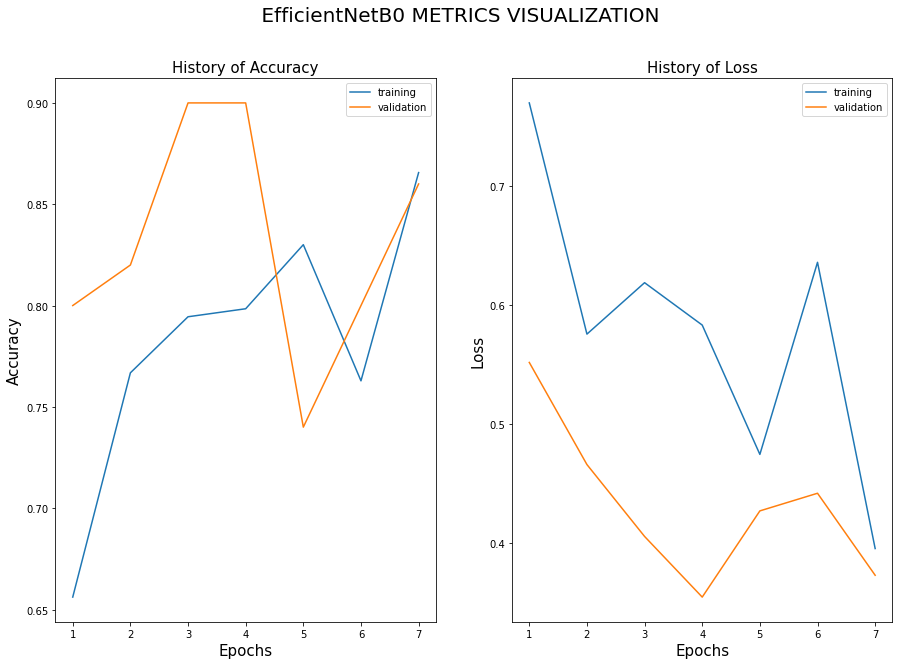

In [29]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" EfficientNetB0 METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [30]:
final_model = keras.models.load_model('resnet_model.h5')

In [31]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
102,PaperedTransparent43v.tif,marked
317,PaperedMixed24v.tif,marked
38,PaperedControl58v.tif,marked
374,PaperedControl16v.tif,marked
139,PaperedTransparent80v.tif,marked
217,NoPaperedGreen59v.tif,unmarked
265,NoPaperedMixed22v.tif,unmarked
328,PaperedMixed35v.tif,marked
65,PaperedTransparent6v.tif,marked
60,PaperedTransparent1v.tif,marked


In [32]:
nb_samples = tmp_df1.shape[0]

In [35]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10 validated image filenames.


In [36]:
predict = final_model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [37]:
tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
102,PaperedTransparent43v.tif,marked,marked
317,PaperedMixed24v.tif,marked,marked
38,PaperedControl58v.tif,marked,marked
374,PaperedControl16v.tif,marked,marked
139,PaperedTransparent80v.tif,marked,unmarked
217,NoPaperedGreen59v.tif,unmarked,unmarked
265,NoPaperedMixed22v.tif,unmarked,unmarked
328,PaperedMixed35v.tif,marked,marked
65,PaperedTransparent6v.tif,marked,marked
60,PaperedTransparent1v.tif,marked,unmarked


In [38]:
to_samples = df.shape[0]

In [40]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator1 = test_gen.flow_from_dataframe(
    df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 379 validated image filenames.


In [41]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [42]:
predict

array([[0.6316391 , 0.3522658 ],
       [0.6914397 , 0.32326633],
       [0.51903963, 0.4353368 ],
       [0.58701974, 0.37688   ],
       [0.6278571 , 0.33715284],
       [0.61369646, 0.4141426 ],
       [0.65133464, 0.2701111 ],
       [0.5742587 , 0.33805487],
       [0.65352595, 0.31300157],
       [0.6810241 , 0.3064588 ],
       [0.62221134, 0.3449419 ],
       [0.64588267, 0.28799027],
       [0.5949188 , 0.32454544],
       [0.7075572 , 0.23858762],
       [0.6125962 , 0.32526827],
       [0.62405324, 0.35083497],
       [0.5228413 , 0.42620522],
       [0.6159332 , 0.2846008 ],
       [0.691039  , 0.33039808],
       [0.5611923 , 0.3707209 ],
       [0.59835136, 0.42740124],
       [0.70898855, 0.26771623],
       [0.7084064 , 0.31022844],
       [0.4562676 , 0.5223779 ],
       [0.62419647, 0.31294486],
       [0.55406964, 0.45001015],
       [0.40867174, 0.5441758 ],
       [0.4989653 , 0.4408788 ],
       [0.52610767, 0.30773473],
       [0.43994787, 0.40160853],
       [0.

In [43]:
df['prediction'] = np.argmax(predict, axis=-1)
df["prediction"] = df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
df

,filename,category,prediction
0,PaperedControl21v.tif,marked,marked
1,PaperedControl22v.tif,marked,marked
2,PaperedControl23v.tif,marked,marked
3,PaperedControl24v.tif,marked,marked
4,PaperedControl25v.tif,marked,marked
...,...,...,...
374,PaperedControl16v.tif,marked,marked
375,PaperedControl17v.tif,marked,marked
376,PaperedControl18v.tif,marked,marked
377,PaperedControl19v.tif,marked,marked


In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(df['category'])
y_pred=list(df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

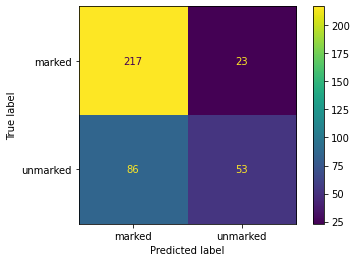

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d") 

In [49]:
final_modell = keras.models.load_model("resnet_model.h5")

In [51]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize((224,224))
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_modell.predict(image)))
tmp_df1["prediction1"]=preds

In [52]:
tmp_df1["prediction1"] = tmp_df1["prediction1"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction,prediction1
102,PaperedTransparent43v.tif,marked,marked,marked
317,PaperedMixed24v.tif,marked,marked,marked
38,PaperedControl58v.tif,marked,marked,marked
374,PaperedControl16v.tif,marked,marked,marked
139,PaperedTransparent80v.tif,marked,unmarked,marked
217,NoPaperedGreen59v.tif,unmarked,unmarked,unmarked
265,NoPaperedMixed22v.tif,unmarked,unmarked,unmarked
328,PaperedMixed35v.tif,marked,marked,marked
65,PaperedTransparent6v.tif,marked,marked,marked
60,PaperedTransparent1v.tif,marked,unmarked,unmarked
